Note on issues with using LAUNCH data: Following the initial classification exercises, there are only four points of unsuccessful launches against 122 successful launches in the given data. Thus, any form of classification based on launch data will be compromised since the binary outcome is not varied. The models can only predict reliably if they are given an output variable that exhibits satisfactory variance (0,1) for each feature value. For this purpose, in the GridSearch Cross Validation we set cv=3.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#The confusion matrix figure function, I will use this for all the other classification models
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
score_df = pd.DataFrame(columns = ["Accuracy Score","F1 Score","Jaccard Score","Log Loss"])

In [4]:
pd.set_option('display.max_columns',None) #display all column names in the dataframe
pd.set_option('display.max_colwidth',None) #display all the data in the dataframe

In [5]:
from sklearn.metrics import accuracy_score, jaccard_score, f1_score, log_loss, classification_report, confusion_matrix

In [6]:
from sklearn.model_selection import GridSearchCV

In [7]:
main_data_df = pd.read_csv("spacex_df_pretty.csv")
main_data_df.head()

,Unnamed: 0,Date,Rocket,Launch Site,Launch Latitude,Launch Longitude,Flight Number,Flight,Orbit,Payload (Kg),Land Site,Failed Launch,Successful Launch,gridfins_False,gridfins_True,legs_False,legs_True,reused_False,reused_True,landing_attempt_False,landing_attempt_True,Failed Landing,Successful Landing,Landing ASDS,Landing Ocean,Landing RTLS
0,0,2006-03-24,Falcon 1,Kwajalein Atoll,9.047721,167.743129,1,1,LEO,20.00,NaN,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0
1,1,2007-03-21,Falcon 1,Kwajalein Atoll,9.047721,167.743129,2,1,LEO,128.33,NaN,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0
2,2,2008-09-28,Falcon 1,Kwajalein Atoll,9.047721,167.743129,4,1,LEO,165.00,NaN,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0
3,3,2009-07-13,Falcon 1,Kwajalein Atoll,9.047721,167.743129,5,1,LEO,200.00,NaN,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0
4,4,2010-06-04,Falcon 9,CCSFS SLC 40,28.561857,-80.577366,6,1,LEO,7341.20,NaN,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0


In [8]:
spacex_df = main_data_df.copy()
spacex_df.head()

,Unnamed: 0,Date,Rocket,Launch Site,Launch Latitude,Launch Longitude,Flight Number,Flight,Orbit,Payload (Kg),Land Site,Failed Launch,Successful Launch,gridfins_False,gridfins_True,legs_False,legs_True,reused_False,reused_True,landing_attempt_False,landing_attempt_True,Failed Landing,Successful Landing,Landing ASDS,Landing Ocean,Landing RTLS
0,0,2006-03-24,Falcon 1,Kwajalein Atoll,9.047721,167.743129,1,1,LEO,20.00,NaN,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0
1,1,2007-03-21,Falcon 1,Kwajalein Atoll,9.047721,167.743129,2,1,LEO,128.33,NaN,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0
2,2,2008-09-28,Falcon 1,Kwajalein Atoll,9.047721,167.743129,4,1,LEO,165.00,NaN,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0
3,3,2009-07-13,Falcon 1,Kwajalein Atoll,9.047721,167.743129,5,1,LEO,200.00,NaN,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0
4,4,2010-06-04,Falcon 9,CCSFS SLC 40,28.561857,-80.577366,6,1,LEO,7341.20,NaN,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0


                                       **# CLASSIFICATION MODELS FOR LANDING DATA #**

In [9]:
land_cols = ["Payload (Kg)", "Failed Landing","Successful Landing","Landing ASDS","Landing RTLS","Landing Ocean"]
# We need to get dummy variables for launch site, rocket and orbit #
temp_df = pd.get_dummies(spacex_df,columns=["Rocket","Orbit"])
temp_df[land_cols] = spacex_df[land_cols]

In [10]:
temp_df.head()

,Unnamed: 0,Date,Launch Site,Launch Latitude,Launch Longitude,Flight Number,Flight,Payload (Kg),Land Site,Failed Launch,Successful Launch,gridfins_False,gridfins_True,legs_False,legs_True,reused_False,reused_True,landing_attempt_False,landing_attempt_True,Failed Landing,Successful Landing,Landing ASDS,Landing Ocean,Landing RTLS,Rocket_Falcon 1,Rocket_Falcon 9,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_TLI,Orbit_VLEO
0,0,2006-03-24,Kwajalein Atoll,9.047721,167.743129,1,1,20.00,NaN,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,2007-03-21,Kwajalein Atoll,9.047721,167.743129,2,1,128.33,NaN,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,2008-09-28,Kwajalein Atoll,9.047721,167.743129,4,1,165.00,NaN,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,3,2009-07-13,Kwajalein Atoll,9.047721,167.743129,5,1,200.00,NaN,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,4,2010-06-04,CCSFS SLC 40,28.561857,-80.577366,6,1,7341.20,NaN,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [11]:
x_var_list = ["Payload (Kg)","Rocket_Falcon 1","Rocket_Falcon 9","Landing ASDS","Landing RTLS","Landing Ocean",
              "Orbit_ES-L1","Orbit_HEO","Orbit_ISS","Orbit_LEO","Orbit_MEO","Orbit_PO","Orbit_SO",
             "Orbit_SSO","Orbit_TLI","Orbit_VLEO"]
x_matrix = temp_df[x_var_list]

In [12]:
from sklearn.preprocessing import StandardScaler

x_matrix = StandardScaler().fit(x_matrix).transform(x_matrix)


In [13]:
y_list = list(temp_df["Successful Landing"])

In [14]:
from sklearn.model_selection import train_test_split
#I will keep the same train and testing data for all classification models to not compromise the comparison

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_matrix,y_list,test_size=0.35, random_state=4)

The dependent variable here is the Successful Landing column.

**K-Nearest Neighbour Classification**

In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [17]:
knn_params = {"n_neighbors":np.arange(1,11)}
KnNcv = GridSearchCV(KNeighborsClassifier(),knn_params,cv=4)

In [18]:
KnNcv_model = KnNcv.fit(x_train,y_train)
kn=KnNcv_model.best_params_["n_neighbors"]

In [19]:
KnN = KNeighborsClassifier(n_neighbors=kn)
KnN_model = KnN.fit(x_train,y_train)


In [20]:
y_pred = KnN_model.predict(x_test)
score_df.loc["KNN Classifier","Accuracy Score"] = accuracy_score(y_test,y_pred)
score_df.loc["KNN Classifier","Jaccard Score"] = jaccard_score(y_test,y_pred)
score_df.loc["KNN Classifier","F1 Score"] = f1_score(y_test,y_pred)
score_df.loc["KNN Classifier","Log Loss"] = "NaN"

Normalized confusion matrix
[[1.   0.  ]
 [0.38 0.62]]


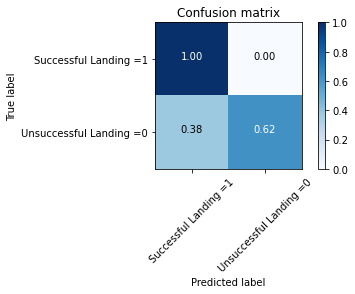

In [21]:
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[1,0])
np.set_printoptions(precision=2)


# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Successful Landing =1','Unsuccessful Landing =0'],normalize= True,  title='Confusion matrix')

In [22]:
score_df

,Accuracy Score,F1 Score,Jaccard Score,Log Loss
KNN Classifier,0.866667,0.90625,0.828571,NaN


**DECISION TREE CLASSIFICATION**

In [23]:
from sklearn.tree import DecisionTreeClassifier

In [24]:
tree_params = {"criterion":["entropy"],"max_depth":np.arange(1,5)}
decTree = DecisionTreeClassifier()
treeGScv = GridSearchCV(decTree,tree_params,cv=4)

In [25]:
treeGScv.fit(x_train,y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy'],
                         'max_depth': array([1, 2, 3, 4])})

In [26]:
treeGScv.best_params_

{'criterion': 'entropy', 'max_depth': 3}

In [27]:
land_tree = DecisionTreeClassifier(max_depth=3,criterion="entropy")
treemodel = land_tree.fit(x_train,y_train)
y_pred_tree = treemodel.predict(x_test)

In [28]:
score_df.loc["Decision Tree Classifier","Accuracy Score"] = accuracy_score(y_test,y_pred_tree)
score_df.loc["Decision Tree Classifier","Jaccard Score"] = jaccard_score(y_test,y_pred_tree)
score_df.loc["Decision Tree Classifier","F1 Score"] = f1_score(y_test,y_pred_tree)
score_df.loc["Decision Tree Classifier","Log Loss"] = "NaN"

In [29]:
score_df

,Accuracy Score,F1 Score,Jaccard Score,Log Loss
KNN Classifier,0.866667,0.90625,0.828571,NaN
Decision Tree Classifier,0.888889,0.920635,0.852941,NaN


In [30]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 
import matplotlib.pyplot as plt

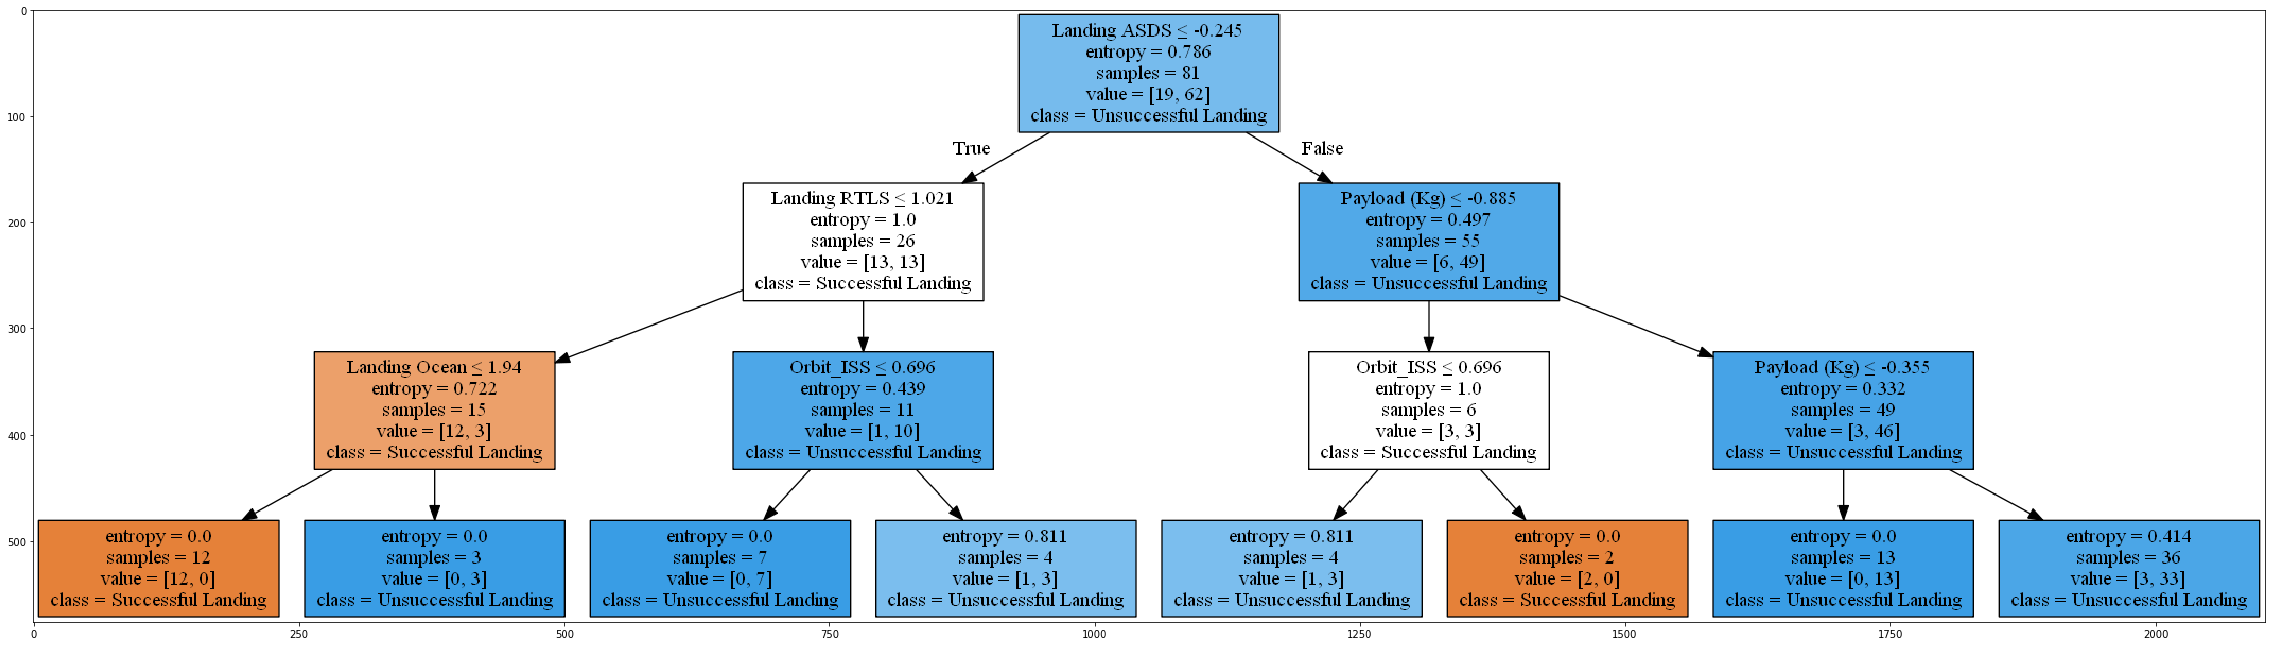

In [31]:
dot_data = StringIO()
filename = "landtree.png"
out=tree.export_graphviz(treemodel,feature_names=list(x_var_list), out_file=dot_data, class_names= ['Successful Landing','Unsuccessful Landing'], filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(40, 75))
plt.imshow(img,interpolation='nearest')

Normalized confusion matrix
[[1.   0.  ]
 [0.31 0.69]]


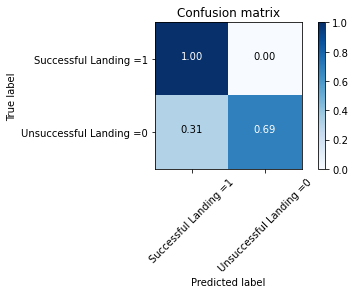

In [32]:
cnf_matrix = confusion_matrix(y_test, y_pred_tree, labels=[1,0])
np.set_printoptions(precision=2)


# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Successful Landing =1','Unsuccessful Landing =0'],normalize= True,  title='Confusion matrix')

In [33]:
print(classification_report(y_test,y_pred_tree))

              precision    recall  f1-score   support

           0       1.00      0.69      0.81        16
           1       0.85      1.00      0.92        29

    accuracy                           0.89        45
   macro avg       0.93      0.84      0.87        45
weighted avg       0.91      0.89      0.88        45



**SUPPORT VECTOR MACHINES**

In [34]:
from sklearn import svm

In [35]:
params_svm = {"kernel":["linear", "poly", "rbf", "sigmoid"]}
svmGrdCV = GridSearchCV(svm.SVC(),params_svm,cv=4)
svmGrdCV_model = svmGrdCV.fit(x_train,y_train)

In [36]:
svmGrdCV_model.best_params_

{'kernel': 'linear'}

In [37]:
y_pred_svm = svmGrdCV_model.predict(x_test)
score_df.loc["Support Vector Classifier","Accuracy Score"] = accuracy_score(y_test,y_pred_svm)
score_df.loc["Support Vector Classifier","Jaccard Score"] = jaccard_score(y_test,y_pred_svm)
score_df.loc["Support Vector Classifier","F1 Score"] = f1_score(y_test,y_pred_svm)
score_df.loc["Support Vector Classifier","Log Loss"] = "NaN"

Normalized confusion matrix
[[1.   0.  ]
 [0.31 0.69]]


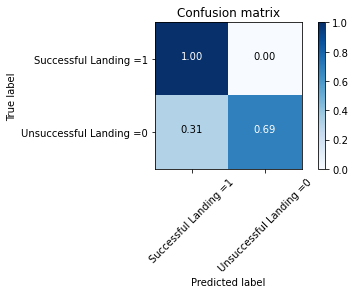

In [38]:
cnf_matrix = confusion_matrix(y_test, y_pred_svm, labels=[1,0])
np.set_printoptions(precision=2)


# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Successful Landing =1','Unsuccessful Landing =0'],normalize= True,  title='Confusion matrix')

In [39]:
score_df

,Accuracy Score,F1 Score,Jaccard Score,Log Loss
KNN Classifier,0.866667,0.90625,0.828571,NaN
Decision Tree Classifier,0.888889,0.920635,0.852941,NaN
Support Vector Classifier,0.888889,0.920635,0.852941,NaN


**Logistic Regression Classifier**

This is the classification method based on the sigmoid function . There are not any parameters that we need to permute over, so the Grid Search Cross Validation would be redundant. We use the liblinear solver.

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
logreg = LogisticRegression(C=0.01,solver="liblinear")
logreg_model = logreg.fit(x_train,y_train)
y_pred_prob = logreg_model.predict_proba(x_test)
y_pred_logreg = logreg_model.predict(x_test)

In [42]:
score_df.loc["Logistic Regression Classifier","Accuracy Score"] = accuracy_score(y_test,y_pred_logreg)
score_df.loc["Logistic Regression Classifier","Jaccard Score"] = jaccard_score(y_test,y_pred_logreg)
score_df.loc["Logistic Regression Classifier","F1 Score"] = f1_score(y_test,y_pred_logreg)
score_df.loc["Logistic Regression Classifier","Log Loss"] = log_loss(y_test,y_pred_prob)

In [43]:
score_df

,Accuracy Score,F1 Score,Jaccard Score,Log Loss
KNN Classifier,0.866667,0.90625,0.828571,NaN
Decision Tree Classifier,0.888889,0.920635,0.852941,NaN
Support Vector Classifier,0.888889,0.920635,0.852941,NaN
Logistic Regression Classifier,0.822222,0.862069,0.757576,0.624098


In [44]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

Text(0.5, 1.0, 'Classification Scores of Supervised Classification Models')

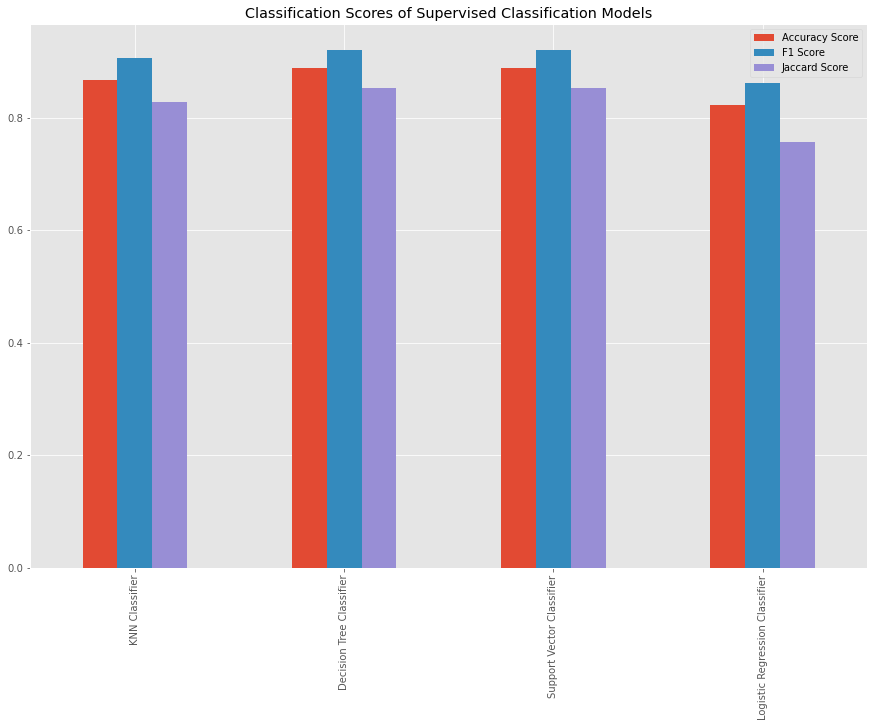

In [45]:
fig,ax = plt.subplots(figsize=(15,10))
score_df.plot(kind="bar",ax=ax)
plt.title("Classification Scores of Supervised Classification Models")

In [48]:
y_pred_svm == y_pred_tree

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])